# K-fold cross validation - Regression Model
Based on the [Ludwig regression example](https://uber.github.io/ludwig/examples/#simple-regression-fuel-efficiency-prediction)  

[Data set](https://archive.ics.uci.edu/ml/datasets/auto+mpg)

This example demonstrates teh following:

- Download a data set and create a pandas dataframe
- Create a training and hold-out test data sets
- Create a Ludwig model definition data structure from the pandas dataframe
- Run a 5-fold cross validation analysis with the training data
- Use Ludwig APIs to train and assess model performance on hold-out test data set

In [1]:
import logging
import os
import os.path
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import scipy.stats as stats
import seaborn as sns
from sklearn.model_selection import train_test_split

from ludwig.api import kfold_cross_validate, LudwigModel

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## Contstants

In [2]:
DATA_SET_URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
DATA_SET = 'auto_mpg.data'
RESULTS_DIR = 'results'

## Clean out previous results

In [3]:
if os.path.isfile(DATA_SET):
    os.remove(DATA_SET)
    
shutil.rmtree(RESULTS_DIR, ignore_errors=True)

## Retrieve data from UCI Machine Learning Repository

### Download required data

In [4]:
r = requests.get(DATA_SET_URL)
if r.status_code == 200:
    with open(DATA_SET,'w') as f:
        f.write(r.content.decode("utf-8"))

### Create Pandas DataFrame from downloaded data

In [5]:
raw_df = pd.read_csv(DATA_SET,
                     header=None,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)


raw_df.columns = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'ModelYear', 'Origin']
raw_df.shape

(398, 8)

In [6]:
raw_df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


### Create train/test split

In [7]:
train_df, test_df = train_test_split(raw_df, train_size=0.8, random_state=17)
print(train_df.shape)
print(test_df.shape)

(318, 8)
(80, 8)


## Setup Ludwig model definition

In [8]:
num_features = ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'ModelYear']
cat_features = ['Origin']

### Create Ludwig input_features

In [9]:
input_features = []
# setup input features for numerical variables
for p in num_features:
    a_feature = {'name': p, 'type': 'numerical', 
                'preprocessing': {'missing_value_strategy': 'fill_with_mean', 'normalization': 'zscore'}}
    input_features.append(a_feature)

# setkup input features for categorical variables
for p in cat_features:
    a_feature = {'name': p, 'type': 'category'}

### Create Ludwig output features

In [10]:
output_features =[
    {
        'name': 'MPG',
        'type': 'numerical',
        'num_fc_layers': 2,
        'fc_size': 64
    }
]

In [11]:
model_definition = {
    'input_features' : input_features,
    'output_features': output_features,
    'training' :{
        'epochs': 100,
        'batch_size': 32
    }
}
model_definition

{'input_features': [{'name': 'Cylinders',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'Displacement',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'Horsepower',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'Weight',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'Acceleration',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'ModelYear',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}}],
 'output_features': [{'name': 'MPG',
   'type': 'numerical',
   'num_fc_layers': 2,
   'fc_size': 64}

## Perform K-fold Cross Validation analysis

In [12]:
%%time
with tempfile.TemporaryDirectory() as tmpdir:
    data_csv_fp = os.path.join(tmpdir,'train.csv')
    train_df.to_csv(data_csv_fp, index=False)

    (
        kfold_cv_stats, 
        kfold_split_indices 
    ) = kfold_cross_validate(
        num_folds=5,
        model_definition=model_definition,
        data_csv=data_csv_fp,
        output_directory=tmpdir,
        logging_level='error'
    )


starting 5-fold cross validation
training on fold 1
Experiment name: cross_validation
Model name: fold_1
Output path: /tmp/tmpbitzgrhm/tmp_e392udw/results/cross_validation_fold_1


ludwig_version: '0.2.1'
command: ('/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py -f '
 '/root/.local/share/jupyter/runtime/kernel-aa878d43-f2ff-4f3b-bf75-be0af7da7427.json')
commit_hash: 'b284848bc7f9'
random_seed: 42
model_definition: {   'combiner': {'type': 'concat'},
    'input_features': [   {   'name': 'Cylinders',
                              'preprocessing': {   'missing_value_strategy': 'fill_with_mean',
                                                   'normalization': 'zscore'},
                              'tied_weights': None,
                              'type': 'numerical'},
                          {   'name': 'Displacement',
                              'preprocessing': {   'missing_value_strategy': 'fill_with_mean',
                                                   'no



Using training dataframe
Building dataset (it may take a while)
Training set: 254
Test set: 64

╒══════════╕
│ TRAINING │
╘══════════╛



Epoch   1
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 406.46it/s]
Took 0.2363s
╒═══════╤══════════╤══════════════════════╤═══════════════════════╤═════════╤═════════╕
│ MPG   │     loss │   mean_squared_error │   mean_absolute_error │      r2 │   error │
╞═══════╪══════════╪══════════════════════╪═══════════════════════╪═════════╪═════════╡
│ train │ 664.4253 │             664.4253 │               24.4020 │ -0.3060 │ 24.4020 │
├───────┼──────────┼──────────────────────┼───────────────────────┼─────────┼─────────┤
│ test  │ 639.2553 │             639.2553 │               24.2597 │ -0.4018 │ 24.2597 │
╘═══════╧══════════╧══════════════════════╧═══════════════════════╧═════════╧═════════╛


Epoch   2
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 377.39it/s]
Took 0.5335s
╒═══════╤══════════╤══════════════════════╤═══════════════════════



Epoch  11
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 408.54it/s]
Took 0.4823s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 45.6660 │              45.6660 │                5.4745 │ 0.0084 │  1.8127 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 40.7815 │              40.7815 │                4.9571 │ 0.0037 │ -0.2936 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  12
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 469.63it/s]
Took 0.4546s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 579.64it/s]
Took 0.4326s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 20.2243 │              20.2243 │                3.2675 │ 0.0208 │  0.7062 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 23.3628 │              23.3628 │                3.7149 │ 0.0155 │ -0.9858 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  32
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 631.77it/s]
Took 0.4600s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 424.31it/s]
Took 0.4896s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 14.7729 │              14.7729 │                2.8178 │ 0.0237 │  0.4283 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 18.6707 │              18.6707 │                3.3710 │ 0.0186 │ -0.9496 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  52
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 464.82it/s]
Took 0.4791s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 534.10it/s]
Took 0.4314s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 11.7188 │              11.7188 │                2.5101 │ 0.0253 │  0.3032 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 15.3853 │              15.3853 │                3.0371 │ 0.0209 │ -0.8996 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  72
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 516.29it/s]
Took 0.4470s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 612.62it/s]
Took 0.4305s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │  9.9362 │               9.9362 │                2.3069 │ 0.0262 │  0.2306 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 13.2698 │              13.2698 │                2.8027 │ 0.0223 │ -0.8539 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  92
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 621.42it/s]
Took 0.4662s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════



Using training dataframe
Building dataset (it may take a while)
Training set: 254
Test set: 64

╒══════════╕
│ TRAINING │
╘══════════╛


Epoch   1
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 403.40it/s]
Took 0.2352s
╒═══════╤══════════╤══════════════════════╤═══════════════════════╤═════════╤═════════╕
│ MPG   │     loss │   mean_squared_error │   mean_absolute_error │      r2 │   error │
╞═══════╪══════════╪══════════════════════╪═══════════════════════╪═════════╪═════════╡
│ train │ 663.6155 │             663.6155 │               24.4062 │ -0.3050 │ 24.4062 │
├───────┼──────────┼──────────────────────┼───────────────────────┼─────────┼─────────┤
│ test  │ 640.5717 │             640.5717 │               24.2025 │ -0.3858 │ 24.2025 │
╘═══════╧══════════╧══════════════════════╧═══════════════════════╧═════════╧═════════╛


Epoch   2
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 548.45it/s]
Took 0.5166s
╒═══════╤══════════╤══════════════════════╤═══════════════════════╤



Epoch  11
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 530.56it/s]
Took 0.5476s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 44.5796 │              44.5796 │                5.3874 │ 0.0086 │  1.3386 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 43.3844 │              43.3844 │                5.1733 │ 0.0007 │  2.9033 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  12
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 473.77it/s]
Took 0.5262s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 625.46it/s]
Took 0.4315s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 21.0161 │              21.0161 │                3.4200 │ 0.0208 │  0.6888 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 21.1207 │              21.1207 │                3.2000 │ 0.0159 │  1.5382 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  32
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 635.93it/s]
Took 0.4355s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 563.11it/s]
Took 0.4690s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 16.0671 │              16.0671 │                2.9829 │ 0.0233 │  0.4723 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 15.0211 │              15.0211 │                2.7263 │ 0.0203 │  1.1505 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  52
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 585.10it/s]
Took 0.4443s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 494.99it/s]
Took 0.4571s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 13.1269 │              13.1269 │                2.6755 │ 0.0248 │  0.3451 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 11.2693 │              11.2693 │                2.4131 │ 0.0231 │  0.9618 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  72
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 591.04it/s]
Took 0.4336s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 622.39it/s]
Took 0.4319s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 11.1171 │              11.1171 │                2.4428 │ 0.0259 │  0.2591 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │  8.9790 │               8.9790 │                2.2061 │ 0.0248 │  0.8757 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  92
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 484.97it/s]
Took 0.4444s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════



Using training dataframe
Building dataset (it may take a while)
Training set: 254
Test set: 64

╒══════════╕
│ TRAINING │
╘══════════╛


Epoch   1
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 476.06it/s]
Took 0.2147s
╒═══════╤══════════╤══════════════════════╤═══════════════════════╤═════════╤═════════╕
│ MPG   │     loss │   mean_squared_error │   mean_absolute_error │      r2 │   error │
╞═══════╪══════════╪══════════════════════╪═══════════════════════╪═════════╪═════════╡
│ train │ 636.6743 │             636.6743 │               24.0056 │ -0.3618 │ 24.0056 │
├───────┼──────────┼──────────────────────┼───────────────────────┼─────────┼─────────┤
│ test  │ 747.1242 │             747.1242 │               25.7788 │ -0.2689 │ 25.7788 │
╘═══════╧══════════╧══════════════════════╧═══════════════════════╧═════════╧═════════╛


Epoch   2
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 388.04it/s]
Took 0.5437s
╒═══════╤══════════╤══════════════════════╤═══════════════════════╤



Epoch  11
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 396.70it/s]
Took 0.5115s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 42.7250 │              42.7250 │                5.3075 │ 0.0040 │  1.5245 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 59.8369 │              59.8369 │                6.2309 │ 0.0072 │  1.2084 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  12
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 537.21it/s]
Took 0.4941s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 670.93it/s]
Took 0.4459s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 19.5573 │              19.5573 │                3.2348 │ 0.0188 │  0.6917 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 27.6338 │              27.6338 │                4.0345 │ 0.0203 │ -0.1324 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  32
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 410.30it/s]
Took 0.4656s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 577.53it/s]
Took 0.4457s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 14.1387 │              14.1387 │                2.7216 │ 0.0224 │  0.4329 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 22.3939 │              22.3939 │                3.6262 │ 0.0224 │ -0.4294 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  52
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 629.78it/s]
Took 0.4712s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 630.15it/s]
Took 0.4560s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 10.8949 │              10.8949 │                2.3794 │ 0.0245 │  0.2917 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 19.1080 │              19.1080 │                3.2831 │ 0.0237 │ -0.4639 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  72
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 542.71it/s]
Took 0.4503s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 517.18it/s]
Took 0.4449s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │  8.9848 │               8.9848 │                2.1754 │ 0.0257 │  0.2227 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 17.0822 │              17.0822 │                3.0913 │ 0.0245 │ -0.4587 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  92
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 596.80it/s]
Took 0.4283s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════



Using training dataframe
Building dataset (it may take a while)
Training set: 255
Test set: 63

╒══════════╕
│ TRAINING │
╘══════════╛


Epoch   1
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 415.65it/s]
Took 0.2235s
╒═══════╤══════════╤══════════════════════╤═══════════════════════╤═════════╤═════════╕
│ MPG   │     loss │   mean_squared_error │   mean_absolute_error │      r2 │   error │
╞═══════╪══════════╪══════════════════════╪═══════════════════════╪═════════╪═════════╡
│ train │ 665.3448 │             665.3448 │               24.5009 │ -0.3204 │ 24.5009 │
├───────┼──────────┼──────────────────────┼───────────────────────┼─────────┼─────────┤
│ test  │ 632.8999 │             632.8999 │               23.8173 │ -0.2904 │ 23.8173 │
╘═══════╧══════════╧══════════════════════╧═══════════════════════╧═════════╧═════════╛


Epoch   2
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 455.31it/s]
Took 0.5133s
╒═══════╤══════════╤══════════════════════╤═══════════════════════╤



Epoch  11
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 380.04it/s]
Took 0.5083s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 45.1593 │              45.1593 │                5.3977 │ 0.0074 │  1.5216 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 43.0690 │              43.0690 │                5.4851 │ 0.0092 │  2.2269 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  12
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 597.18it/s]
Took 0.4591s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 641.23it/s]
Took 0.4758s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 21.4463 │              21.4463 │                3.4319 │ 0.0202 │  0.7125 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 19.7742 │              19.7742 │                3.2998 │ 0.0214 │  1.7746 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  32
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 545.64it/s]
Took 0.4502s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 536.08it/s]
Took 0.4288s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 15.7441 │              15.7441 │                2.9423 │ 0.0232 │  0.4505 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 15.0506 │              15.0506 │                2.9211 │ 0.0239 │  1.4102 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  52
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 474.31it/s]
Took 0.4725s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 529.32it/s]
Took 0.4799s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 12.4096 │              12.4096 │                2.6312 │ 0.0249 │  0.3037 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 12.5967 │              12.5967 │                2.6838 │ 0.0251 │  1.1605 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  72
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 503.00it/s]
Took 0.4640s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 564.89it/s]
Took 0.4695s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 10.4639 │              10.4639 │                2.4166 │ 0.0259 │  0.2200 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 11.0655 │              11.0655 │                2.4994 │ 0.0259 │  1.0231 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  92
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 545.28it/s]
Took 0.4358s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════



Using training dataframe
Building dataset (it may take a while)
Training set: 255
Test set: 63

╒══════════╕
│ TRAINING │
╘══════════╛


Epoch   1
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 392.36it/s]
Took 0.2289s
╒═══════╤══════════╤══════════════════════╤═══════════════════════╤═════════╤═════════╕
│ MPG   │     loss │   mean_squared_error │   mean_absolute_error │      r2 │   error │
╞═══════╪══════════╪══════════════════════╪═══════════════════════╪═════════╪═════════╡
│ train │ 666.4475 │             666.4475 │               24.5396 │ -0.3508 │ 24.5396 │
├───────┼──────────┼──────────────────────┼───────────────────────┼─────────┼─────────┤
│ test  │ 636.2145 │             636.2145 │               23.7847 │ -0.2701 │ 23.7847 │
╘═══════╧══════════╧══════════════════════╧═══════════════════════╧═════════╧═════════╛


Epoch   2
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 436.27it/s]
Took 0.5999s
╒═══════╤══════════╤══════════════════════╤═══════════════════════╤



Epoch  11
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 527.22it/s]
Took 0.5005s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 44.7880 │              44.7880 │                5.4021 │ 0.0056 │  1.5939 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 41.2899 │              41.2899 │                5.4101 │ 0.0122 │  1.8482 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  12
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 423.39it/s]
Took 0.4687s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 415.69it/s]
Took 0.4494s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 20.2250 │              20.2250 │                3.3421 │ 0.0194 │  0.7150 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 23.1184 │              23.1184 │                3.4626 │ 0.0208 │  1.4532 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  32
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 486.44it/s]
Took 0.4489s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 501.38it/s]
Took 0.4394s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 14.5369 │              14.5369 │                2.8785 │ 0.0228 │  0.4492 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 19.1823 │              19.1823 │                2.9729 │ 0.0226 │  1.2134 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  52
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 631.29it/s]
Took 0.4694s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 603.93it/s]
Took 0.4355s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │ 11.3821 │              11.3821 │                2.5596 │ 0.0246 │  0.3033 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 16.1690 │              16.1690 │                2.6486 │ 0.0241 │  0.9319 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  72
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 478.04it/s]
Took 0.4515s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 651.49it/s]
Took 0.4225s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪═══════════════════════╪════════╪═════════╡
│ train │  9.5221 │               9.5221 │                2.3435 │ 0.0257 │  0.2383 │
├───────┼─────────┼──────────────────────┼───────────────────────┼────────┼─────────┤
│ test  │ 14.0502 │              14.0502 │                2.4103 │ 0.0251 │  0.7319 │
╘═══════╧═════════╧══════════════════════╧═══════════════════════╧════════╧═════════╛


Epoch  92
Evaluation test : 100%|██████████| 2/2 [00:00<00:00, 416.62it/s]
Took 0.4675s
╒═══════╤═════════╤══════════════════════╤═══════════════════════╤════════╤═════════╕
│ MPG   │    loss │   mean_squared_error │   mean_absolute_error │     r2 │   error │
╞═══════╪═════════╪══════════════════════╪════════════════

In [13]:
kfold_cv_stats['overall']['MPG']

{'loss_mean': 12.219038321479918,
 'loss_std': 2.7709872829222606,
 'mean_squared_error_mean': 12.219038321479918,
 'mean_squared_error_std': 2.7709872829222606,
 'mean_absolute_error_mean': 2.5341584652189226,
 'mean_absolute_error_std': 0.31310618614114655,
 'r2_mean': 0.024907988079247025,
 'r2_std': 0.001173805535266707,
 'error_mean': 0.23876642192166947,
 'error_std': 0.7404382677235258}

## Train model and assess model performance

In [14]:
model = LudwigModel(
    model_definition=model_definition,
    logging_level=logging.ERROR
)

In [15]:
%%time
training_stats = model.train(
    data_train_df=train_df,
    output_directory=RESULTS_DIR,
)

CPU times: user 14.2 s, sys: 1.27 s, total: 15.5 s
Wall time: 20.4 s


In [16]:
mpg_hat_df, test_stats = model.test(data_df=test_df)

/opt/project/ludwig/data/preprocessing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_df[feature['name']].mean(),
/opt/project/ludwig/data/preprocessing.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preprocessing_parameters['fill_value'],


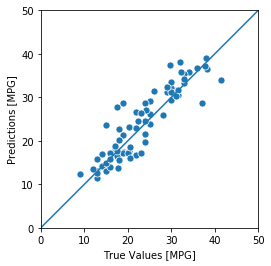

In [17]:
a = plt.axes(aspect='equal')
sns.scatterplot(test_df['MPG'].values, mpg_hat_df['MPG_predictions'].values,
               s=50)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


## Compare K-fold Cross Validation metrics against hold-out test metrics

### Hold-out Test Metrics

In [18]:
test_stats['MPG']

{'loss': 11.88073501586914,
 'mean_squared_error': 11.88073501586914,
 'mean_absolute_error': 2.5777830123901366,
 'r2': 0.009921323508024216,
 'error': -0.5858805656433106}

### K-fold Cross Validation Metrics

In [19]:
kfold_cv_stats['overall']['MPG']

{'loss_mean': 12.219038321479918,
 'loss_std': 2.7709872829222606,
 'mean_squared_error_mean': 12.219038321479918,
 'mean_squared_error_std': 2.7709872829222606,
 'mean_absolute_error_mean': 2.5341584652189226,
 'mean_absolute_error_std': 0.31310618614114655,
 'r2_mean': 0.024907988079247025,
 'r2_std': 0.001173805535266707,
 'error_mean': 0.23876642192166947,
 'error_std': 0.7404382677235258}